In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
Ravdess = "/content/audio_speech_actors_01-24/"
Crema = "/content/AudioWAV/"
Tess = "/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/content/ALL/"

In [ ]:
!kaggle datasets download -d ejlok1/cremad
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess
!kaggle datasets download -d ejlok1/surrey-audiovisual-expressed-emotion-savee
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

Dataset URL: https://www.kaggle.com/datasets/ejlok1/cremad
License(s): ODC Attribution License (ODC-By)
 98% 444M/451M [00:09<00:00, 61.0MB/s]
100% 451M/451M [00:09<00:00, 52.1MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)
 98% 420M/428M [00:04<00:00, 84.2MB/s]
100% 428M/428M [00:04<00:00, 98.6MB/s]
Dataset URL: https://www.kaggle.com/datasets/ejlok1/surrey-audiovisual-expressed-emotion-savee
License(s): copyright-authors
 91% 98.0M/107M [00:01<00:00, 84.8MB/s]
100% 107M/107M [00:01<00:00, 87.6MB/s] 
Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 96% 413M/429M [00:04<00:00, 166MB/s]
100% 429M/429M [00:04<00:00, 95.6MB/s]


In [ ]:
#unzipping the cremad
import zipfile
zip_ref = zipfile.ZipFile('/content/cremad.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

#unzipping the tess
import zipfile
zip_ref = zipfile.ZipFile('/content/toronto-emotional-speech-set-tess.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

#unzipping the savee
import zipfile
zip_ref = zipfile.ZipFile('/content/surrey-audiovisual-expressed-emotion-savee.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

#unzipping the ravdess
import zipfile
zip_ref = zipfile.ZipFile('/content/ravdess-emotional-speech-audio.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                   Path
0  neutral  /content/AudioWAV/1014_IEO_NEU_XX.wav
1    angry  /content/AudioWAV/1070_TSI_ANG_XX.wav
2      sad  /content/AudioWAV/1033_IWL_SAD_XX.wav
3    happy  /content/AudioWAV/1012_WSI_HAP_XX.wav
4  neutral  /content/AudioWAV/1031_IWW_NEU_XX.wav

In [ ]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0  surprise  /content/audio_speech_actors_01-24/Actor_18/03...
1      fear  /content/audio_speech_actors_01-24/Actor_18/03...
2  surprise  /content/audio_speech_actors_01-24/Actor_18/03...
3      calm  /content/audio_speech_actors_01-24/Actor_18/03...
4  surprise  /content/audio_speech_actors_01-24/Actor_18/03...

In [ ]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0      sad  /content/tess toronto emotional speech set dat...
1      sad  /content/tess toronto emotional speech set dat...
2      sad  /content/tess toronto emotional speech set dat...
3      sad  /content/tess toronto emotional speech set dat...
4      sad  /content/tess toronto emotional speech set dat...

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                      Path
0  disgust   /content/ALL/KL_d15.wav
1    angry   /content/ALL/KL_a10.wav
2      sad  /content/ALL/DC_sa04.wav
3  neutral   /content/ALL/JE_n22.wav
4    happy   /content/ALL/DC_h11.wav

In [ ]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0  surprise  /content/audio_speech_actors_01-24/Actor_18/03...
1      fear  /content/audio_speech_actors_01-24/Actor_18/03...
2  surprise  /content/audio_speech_actors_01-24/Actor_18/03...
3      calm  /content/audio_speech_actors_01-24/Actor_18/03...
4  surprise  /content/audio_speech_actors_01-24/Actor_18/03...

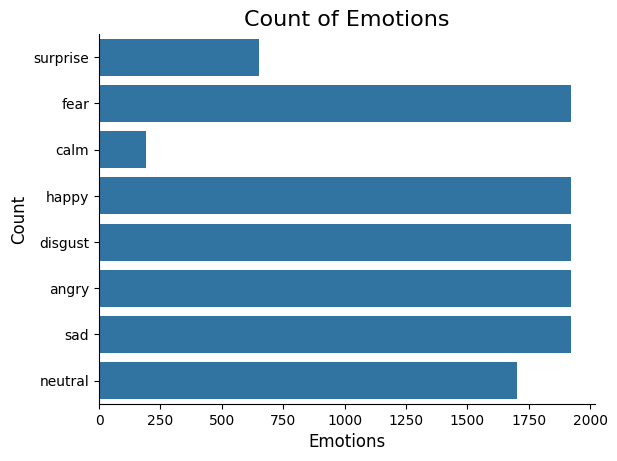

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    # librosa.display.waveplot(data, sr=sr)
    plt.plot(data)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

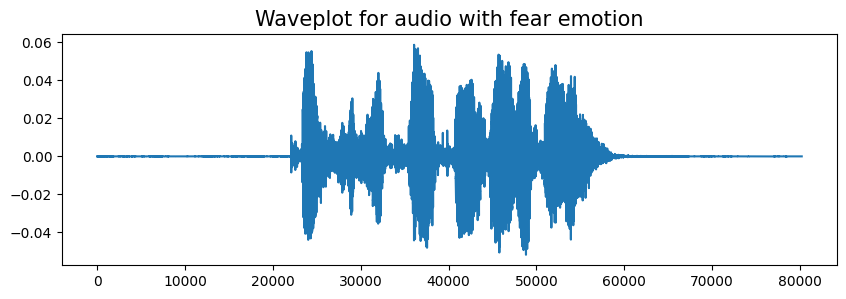

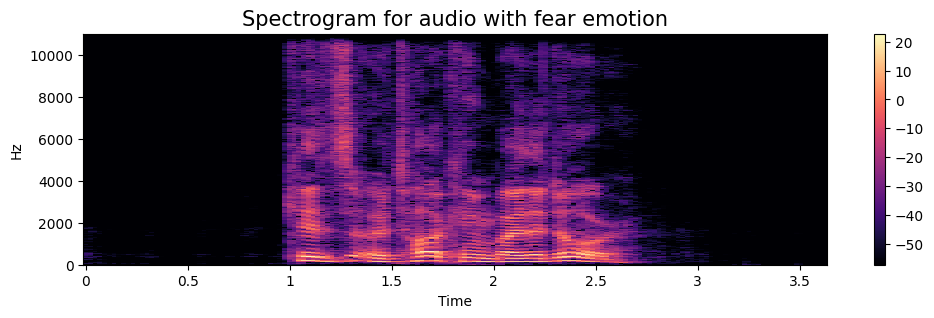

In [ ]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

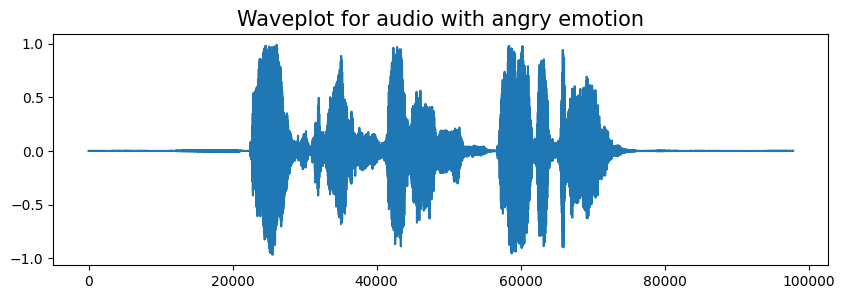

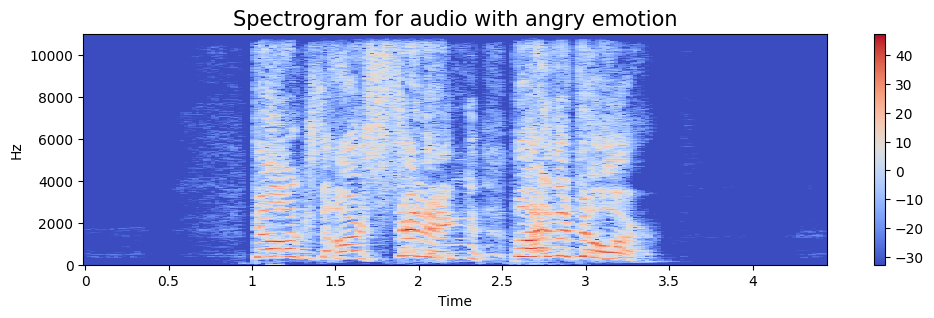

In [ ]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

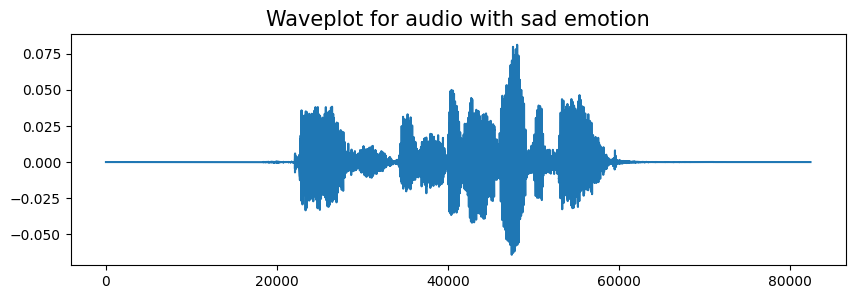

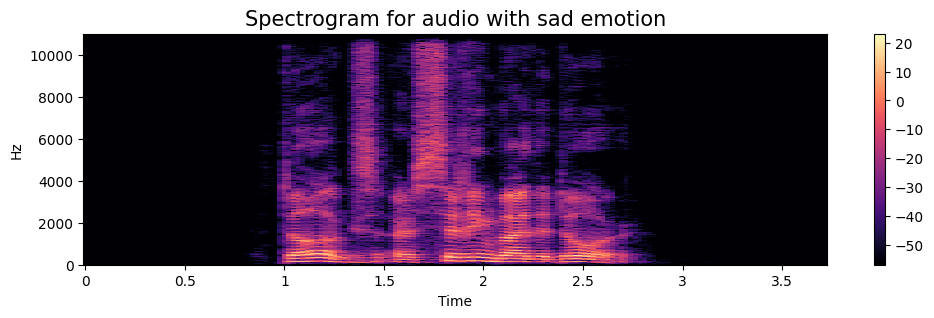

In [ ]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

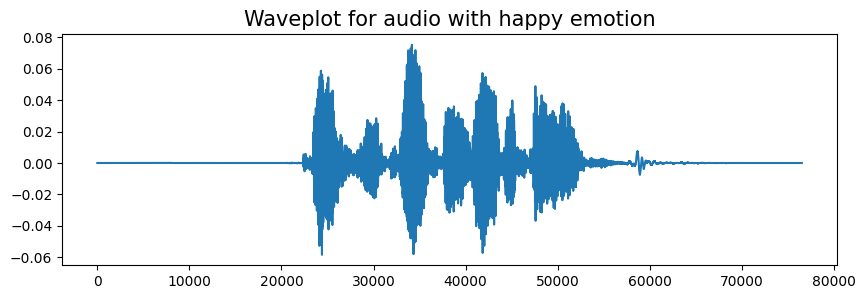

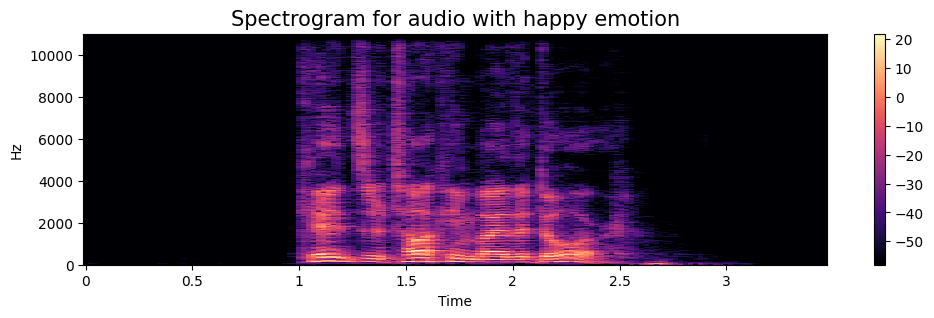

In [ ]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [ ]:
pitch(data, sampling_rate=16000)

array([ 2.0436903e-07, -2.8980332e-07,  3.4612611e-07, ...,
       -4.0677446e-07, -7.9288156e-07,  5.0994316e-07], dtype=float32)

In [ ]:
stretch(data)

array([ 8.0634933e-08, -3.5057663e-08,  9.2345589e-09, ...,
       -3.9409588e-07,  2.0990512e-07, -1.5806663e-07], dtype=float32)

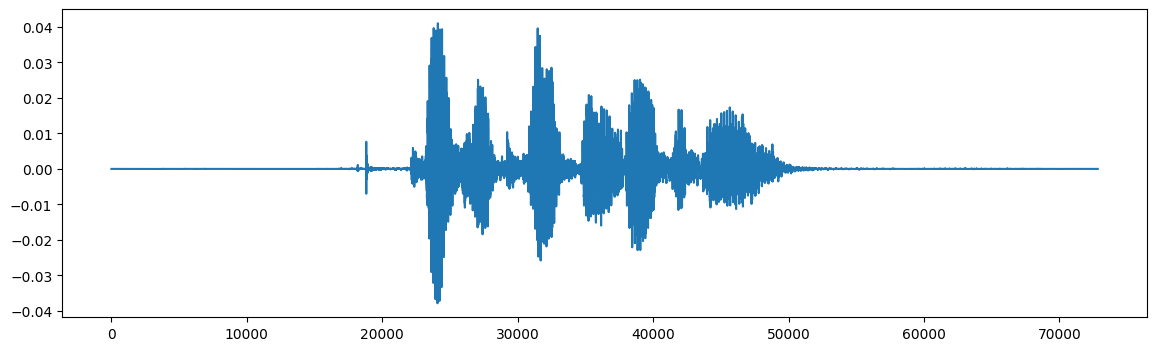

In [ ]:
plt.figure(figsize=(14,4))
plt.plot(data)
Audio(path)

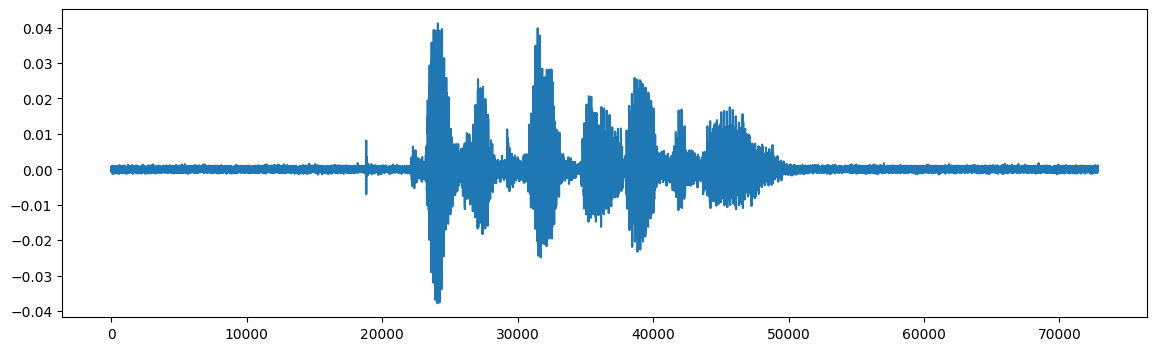

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
# librosa.display.waveplot(y=data, sr=sample_rate)
plt.plot(x)
Audio(x, rate=sample_rate)

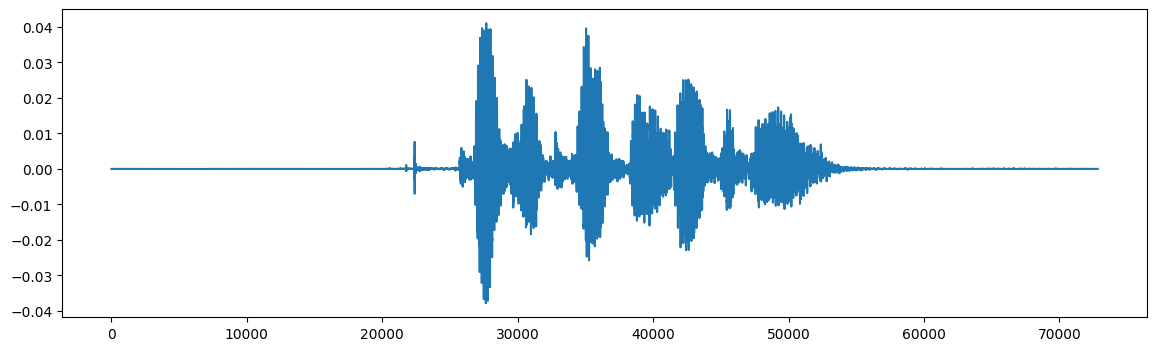

In [ ]:
x = shift(data)
plt.figure(figsize=(14,4))
plt.plot(x)
Audio(x, rate=sample_rate)

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [ ]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.227756  0.627320  0.667514  0.695362  0.749232  0.734184  0.644267   
1  0.212999  0.664112  0.695589  0.711471  0.770877  0.765310  0.681427   
2  0.140003  0.636861  0.676860  0.713574  0.751681  0.753248  0.621361   
3  0.321275  0.729664  0.750033  0.730624  0.735275  0.713529  0.660531   
4  0.315859  0.797668  0.825329  0.807514  0.813495  0.813020  0.705032   

          7         8         9  ...           153           154       155  \
0  0.662989  0.705062  0.704013  ...  5.536878e-06  5.692905e-06  0.000004   
1  0.664119  0.711062  0.715724  ...  7.148753e-06  7.103373e-06  0.000006   
2  0.634006  0.672559  0.673809  ...  7.793537e-07  9.885570e-07  0.000002   
3  0.684966  0.733049  0.753972  ...  4.310902e-06  3.291511e-06  0.000002   
4  0.683633  0.731802  0.763151  ...  4.967314e-05  4.811588e-05  0.000048   

        156       157       158       159       160           161   labels  
0  0.000004  0.000006  0.000009  0.000011  0.000005  4.489416e-07     calm  
1  0.000006  0.000008  0.000010  0.000012  0.000007  1.883447e-06     calm  
2  0.000002  0.000001  0.000001  0.000002  0.000001  1.336162e-07     calm  
3  0.000002  0.000005  0.000008  0.000007  0.000005  4.245835e-07  neutral  
4  0.000046  0.000050  0.000053  0.000053  0.000050  4.387118e-05  neutral  

[5 rows x 163 columns]

In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [ ]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

In [ ]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 162, 256)          1536      
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 81, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_13 (Conv1D)          (None, 81, 256)           327936    
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 41, 256)           0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 41, 128)           163968    
                                                                 
 max_pooling1d_14 (MaxPooli  (None, 21, 128)          

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 206s 477ms/step - loss: 1.6943 - accuracy: 0.3148 - val_loss: 1.4575 - val_accuracy: 0.4331 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 206s 482ms/step - loss: 1.4442 - accuracy: 0.4256 - val_loss: 1.3244 - val_accuracy: 0.4700 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 205s 479ms/step - loss: 1.3588 - accuracy: 0.4593 - val_loss: 1.2626 - val_accuracy: 0.5001 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 207s 483ms/step - loss: 1.3004 - accuracy: 0.4842 - val_loss: 1.2391 - val_accuracy: 0.5012 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 209s 489ms/step - loss: 1.2645 - accuracy: 0.4938 - val_loss: 1.2206 - val_accuracy: 0.5127 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 210s 492ms/step - loss: 1.2341 - accuracy: 0.5100 - val_loss: 1.1760 - val_accuracy: 0.5259 - lr: 0.0010
Epoch 7/50
428/428 [==========================

286/286 [==============================] - 15s 51ms/step - loss: 1.1561 - accuracy: 0.6155
Accuracy of our model on test data :  61.5544855594635 %


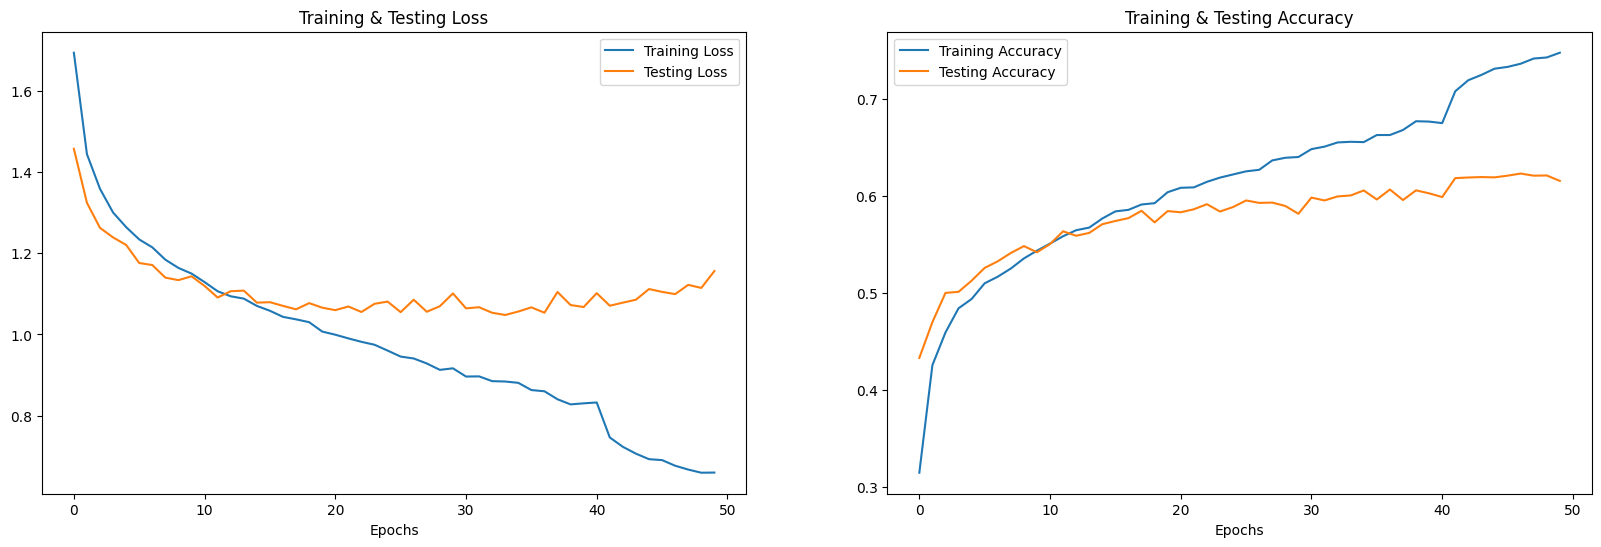

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

286/286 [==============================] - 15s 51ms/step


In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          neutral         happy
1            angry         angry
2         surprise      surprise
3             fear         happy
4          disgust       neutral
5            angry         angry
6         surprise      surprise
7             fear          fear
8            happy         happy
9         surprise      surprise

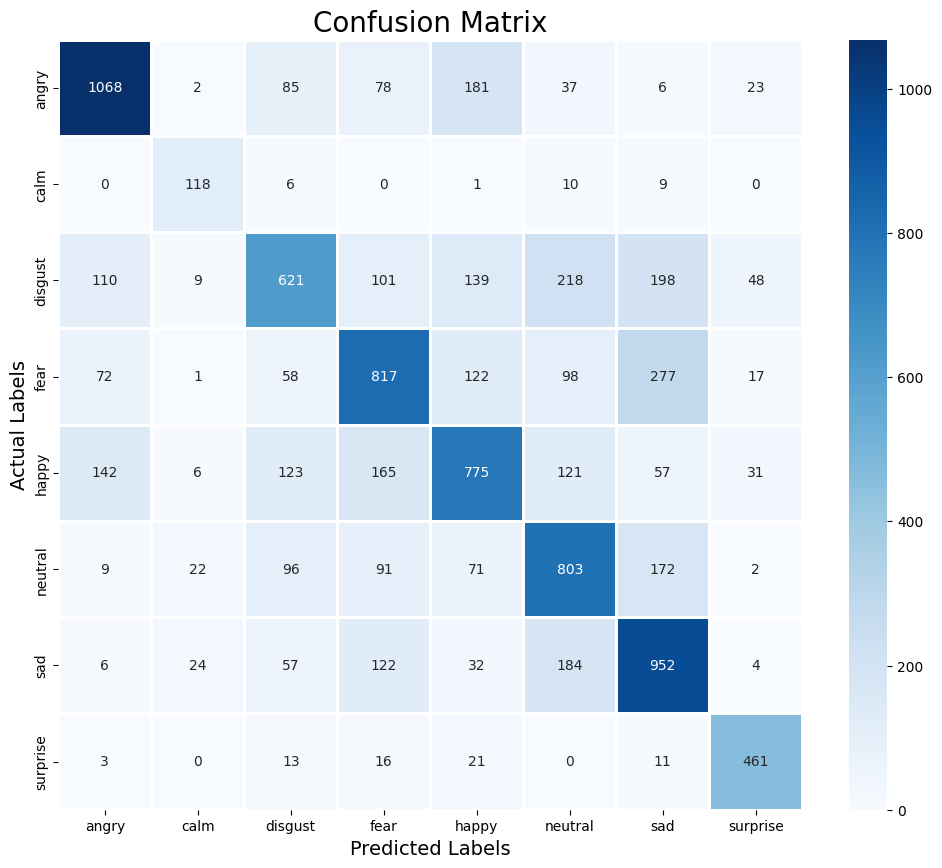

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.76      0.72      0.74      1480
        calm       0.65      0.82      0.72       144
     disgust       0.59      0.43      0.50      1444
        fear       0.59      0.56      0.57      1462
       happy       0.58      0.55      0.56      1420
     neutral       0.55      0.63      0.59      1266
         sad       0.57      0.69      0.62      1381
    surprise       0.79      0.88      0.83       525

    accuracy                           0.62      9122
   macro avg       0.63      0.66      0.64      9122
weighted avg       0.62      0.62      0.61      9122



In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

VGGish

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import numpy as np
import librosa

In [ ]:
# Load the model.
vggish_model = hub.load('https://www.kaggle.com/models/google/vggish/TensorFlow2/vggish/1')

# Input: 3 seconds of silence as mono 16 kHz waveform samples.
waveform = np.zeros(5 * 16000, dtype=np.float32)

# Run the model, check the output.
embeddings = vggish_model(waveform)
embeddings.shape.assert_is_compatible_with([None, 128])
embeddings.shape

TensorShape([5, 128])

In [ ]:
#according to VGGish
def load_wav_16k_mono1(filename):
  audio_path=filename.numpy()
  y, sr = librosa.load(audio_path, sr=16000)
  return y

def preprocess(file_path, label):
    wav = tf .py_function(
        load_wav_16k_mono1, #function here defined
        inp=[file_path], #input
        Tout=(tf.float32)) #output is integer we get

    wav.set_shape([None]) #as sequence can be of arbitary length

    wav = wav[:80000]
    zero_padding = tf.zeros([80000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)

    embeddings = vggish_model(wav)
    embeddings.shape.assert_is_compatible_with([None, 128])

    return embeddings, label

In [ ]:
data_path.head(2)

Emotions                                               Path
0  surprise  /content/audio_speech_actors_01-24/Actor_18/03...
1      fear  /content/audio_speech_actors_01-24/Actor_18/03...

In [ ]:
maxx=0
for i in data_path['Path'].values:
  y=len(load_wav_16k_mono1(i))
  if maxx<y:
    maxx=y
print(maxx)

114220


In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data_path['label']=le.fit_transform(data_path['Emotions'])
data_path.head(2)

Emotions                                               Path  label
0  surprise  /content/audio_speech_actors_01-24/Actor_18/03...      7
1      fear  /content/audio_speech_actors_01-24/Actor_18/03...      3

In [ ]:
from sklearn.model_selection import train_test_split
df_train,df_val=train_test_split(data_path,test_size=0.15,random_state=42, stratify=data_path['label'])
df_train,df_test=train_test_split(df_train,test_size=0.15,random_state=42, stratify=df_train['label'])
df_train.shape,df_test.shape,df_val.shape

((8786, 3), (1551, 3), (1825, 3))

In [ ]:
AUTOTUNE=tf.data.experimental.AUTOTUNE

audio_files =df_train['Path'].values
labels = df_train['label'].values
train = tf.data.Dataset.from_tensor_slices((audio_files, labels))

# Map dataset with the custom loading function
#train = train.map(lambda x, y: tf.numpy_function(preprocess, [x, y], [tf.float32, tf.float32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
train= train.map(preprocess, num_parallel_calls=AUTOTUNE)

train = train.shuffle(buffer_size=100)
train=train.batch(32)
train = train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Iterate over the dataset (for testing purposes)
for audio, label in train.take(1):
    print("Audio shape:", audio.shape)
    print("Label:", label)


Audio shape: (32, 5, 128)
Label: tf.Tensor([5 3 7 6 7 0 5 5 5 3 0 6 6 0 2 2 6 3 3 6 3 5 2 3 2 2 6 6 6 6 0 4], shape=(32,), dtype=int64)


In [ ]:
audio_files = df_val['Path'].values
labels = df_val['label'].values
val = tf.data.Dataset.from_tensor_slices((audio_files, labels))

#dataset = dataset.map(lambda x, y: tf.numpy_function(load_audio, [x, y], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val= val.map(preprocess, num_parallel_calls=AUTOTUNE)

val = val.shuffle(buffer_size=100)
val=val.batch(32)
val = val.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Iterate over the dataset (for testing purposes)
for audio, label in val.take(1):
    print("Audio shape:", audio.shape)
    print("Label:", label)


Audio shape: (32, 5, 128)
Label: tf.Tensor([4 4 2 0 0 2 6 2 6 3 7 6 2 2 2 2 4 5 6 3 2 0 0 1 5 6 2 3 6 3 4 5], shape=(32,), dtype=int64)


In [ ]:
model=keras.Sequential()
#model.add(keras.layers.Input(5,128))
model.add(keras.layers.Flatten(input_shape=(5,128)))
model.add(keras.layers.Dense(256, activation='relu'))
# model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.Dense(8))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 640)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               164096    
                                                                 
 dense_9 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 166152 (649.03 KB)
Trainable params: 166152 (649.03 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
!mkdir /content/drive/MyDrive/project/checkpoint1/
save_callback = keras.callbacks.ModelCheckpoint(
    '/content/drive/MyDrive/project/checkpoint1/', save_weights_only=False, monitor='accuracy', save_best_only=True,
)

mkdir: cannot create directory ‘/content/drive/MyDrive/project/checkpoint1/’: File exists


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(lr=0.001),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=["accuracy"],
)
model.fit(train,
          epochs=1,
          validation_data=val,
          callbacks=[save_callback])

model.evaluate(val, verbose=2)

 33/275 [==>...........................] - ETA: 32:56 - loss: 1.7905 - accuracy: 0.2917